In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import time 
import numpy as np
from tqdm import tqdm

from src.sampler_jax import hmc, hamiltonian_side_move, hamiltonian_walk_move
from src.visualize.corner import corner

# Distibution

In [5]:
# Distribution
dim = 3
true_mean = np.zeros(dim)
precision_matrix = np.eye(dim)

def potential(x):
    """Vectorized negative log density (potential energy)"""        
    # Vectorized operation for all samples
    centered = x - true_mean
    result = 0.5 * jnp.einsum('j,jk,k->', centered, precision_matrix, centered)
        
    return result

# Sampler setup
initial = jnp.zeros(dim)

n_samples = 10**5
burn_in = 10**4


# Utils

In [4]:
def timer(func, num_evals=5):
    times = []
    keys = jax.random.split(jax.random.PRNGKey(0), num_evals)
    for key in keys:
        start = time.perf_counter()
        _, _ = func(key)
        _.block_until_ready()
        elapsed = time.perf_counter() - start
        times.append(elapsed)
        print(f"Time taken: {elapsed:.3f} seconds")

    print('\nStatistics of time taken')
    print('Average: {:.3f} seconds'.format(np.mean(times)))  
    print('Standard deviation: {:.3f} seconds'.format(np.std(times)))

def plot(func, key=jax.random.PRNGKey(0)):
    samples, acceptance_rates = func(key)
    samples = samples.reshape(-1, dim)[-10000:]
    corner(samples)


# HMC

In [16]:
func = lambda key: hmc(potential, 
                       initial, 
                       n_samples,
                       n_chains=10,
                       epsilon=0.1, 
                       L=10, 
                       n_thin=1,
                       key=key)
timer(func)

Time taken: 0.718 seconds
Time taken: 0.379 seconds
Time taken: 0.382 seconds
Time taken: 0.407 seconds
Time taken: 0.379 seconds

Statistics of time taken
Average: 0.453 seconds
Standard deviation: 0.133 seconds


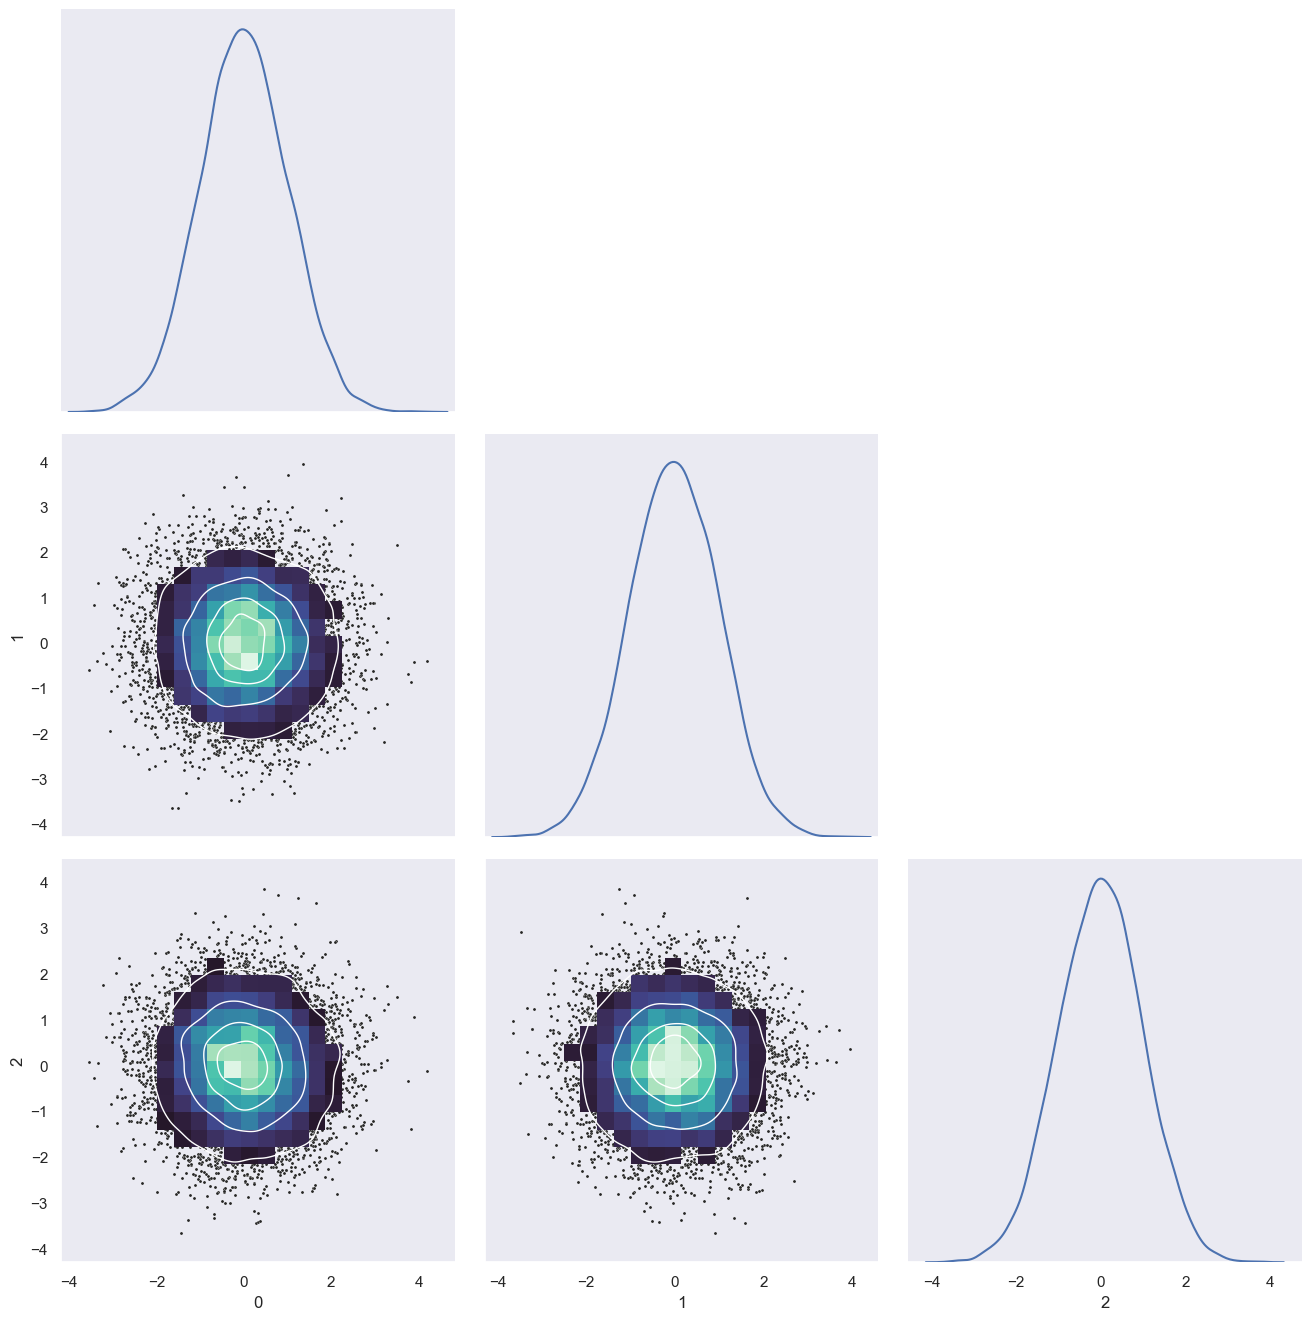

In [10]:
plot(func)

# HMC Side Move

In [5]:
func = lambda key: hamiltonian_side_move(potential, 
                                         initial, 
                                         n_samples, 
                                         n_chains_per_group=5, 
                                         epsilon=0.1, 
                                         L=10, 
                                         beta=1.0, 
                                         n_thin=1)
timer(func)

Time taken: 3.622 seconds
Time taken: 3.153 seconds
Time taken: 3.175 seconds
Time taken: 3.353 seconds
Time taken: 3.538 seconds

Statistics of time taken
Average: 3.368 seconds
Standard deviation: 0.188 seconds


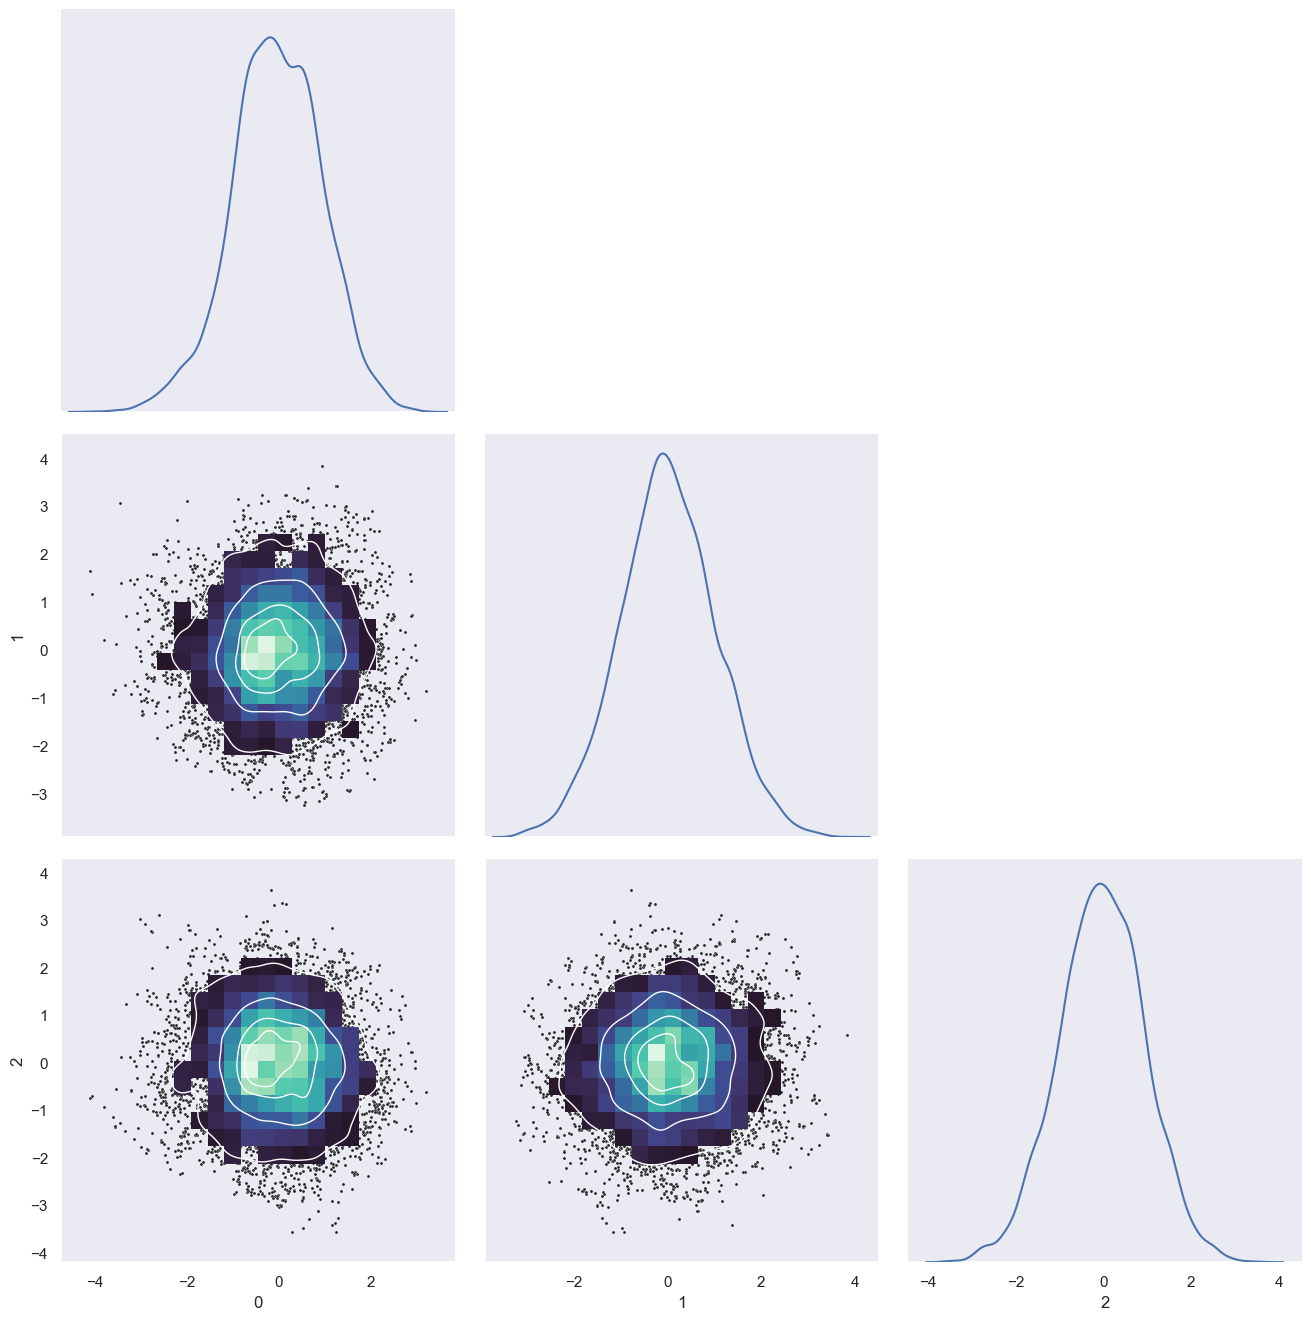

In [7]:
plot(func)

# HMC Walk Move

In [10]:
func = lambda key: hamiltonian_walk_move(potential, 
                                  initial, 
                                  n_samples, 
                                  n_chains_per_group=5, 
                                  epsilon=0.1, 
                                  L=10, 
                                  beta=1.0,
                                  n_thin=1,
                                  key=key)
timer(func)

Time taken: 4.026 seconds
Time taken: 3.621 seconds
Time taken: 3.870 seconds
Time taken: 3.929 seconds
Time taken: 3.719 seconds

Statistics of time taken
Average: 3.833 seconds
Standard deviation: 0.146 seconds


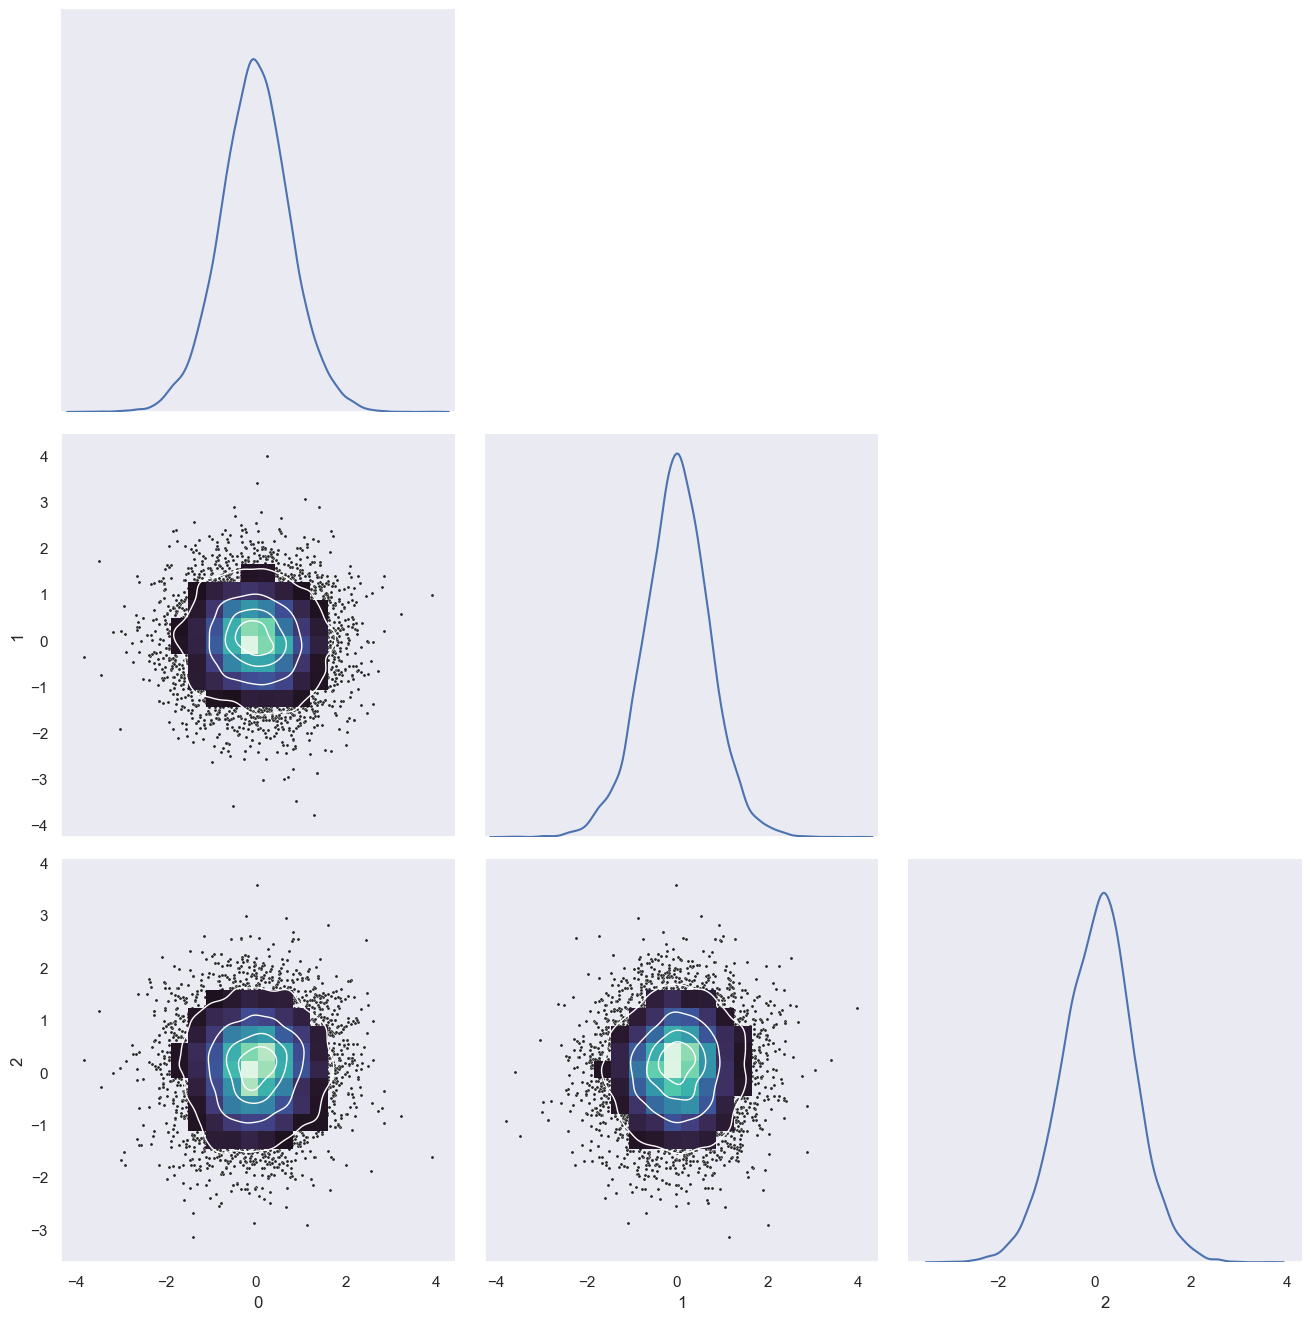

In [11]:
plot(func)

# Autocorrelation Time

In [6]:
from src.autocorr import integrated_time

In [7]:
samples, acceptances = hmc(potential, 
                           initial, 
                           n_samples,
                           n_chains=10,
                           epsilon=0.1, 
                           L=10, 
                           n_thin=1,
                           key=jax.random.PRNGKey(0))

In [8]:
integrated_time(samples)

array([3.33839931, 3.32669819, 3.34710051])